In [1]:
!pip install "gym>=0.21.0"
!pip install tf-agents


In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
import os
import copy
import sys      
import time

import threading
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import torch
import tensorflow as tf
#from gnuradio import gr
#import pmt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax
from tensorflow.keras.layers import Dense

from gym import Env
from gym.spaces import Discrete, Box


#from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
#from matplotlib.figure import Figure
#from PyQt5 import QtCore #conda install pyqt
#from PyQt5 import QtWidgets

import abc
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent

import copy

In [3]:
HISTORY_BUFFER_LEN = 200
DEFAULT_WINDOW_SIZE = 10
EPISODE_LENGTH = 20
NUMBER_OF_EPISODES = 200
seed = 2
time = 0

In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))
num_GPU = 1        
if num_GPU < len(gpus):
  tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
  tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
  print('Only GPU number', num_GPU, 'used')

tf.random.set_seed(seed)

Number of GPUs available : 0


In [5]:
class transmit_wait():
  def __init__(self, sensed = 0 , window_size = DEFAULT_WINDOW_SIZE, history = 0):
    self._action_spec = Discrete(2) #transmit or not {0,1}
    self.initial_state = history 
    self.slient_time = window_size
    self.window_size = window_size	
    self.episode_length = EPISODE_LENGTH
    self.reward = 0
    self.energy = 10
    self.my_actions_history = np.zeros(self.window_size)
    self.urgency = 0

    self._state = history , self.energy, self.slient_time , self.urgency
    self.new_state = self._state

  def reset(self):
    self._state = [self.initial_state , self.sensed , 0]
    self._episode_ended = False
    self.episode_length = EPISODE_LENGTH
    self.reward = 0
    return (self.reward , self._state , 0)

  def step(self, action):
    #history: collision = 0 , clean transmit = 1 , avoided collision = 2 , wasted slot = 3'
    history , energy, silent_time , urgency = self.new_state
    T = 1
    #FIFO actions 
    self.my_actions_history = np.append(self.my_actions_history,action)
    self.my_actions_history = np.delete(self.my_actions_history,0)
    for T in range(1,len(self.my_actions_history)):
      if self.my_actions_history[-T] == 1:
        break
    
       
    count_fairness = 0
    slience = 0
    allow = 0
    collisions = 0
    

    r_P = 0
    if action == 1 and (history[-1] == 0 and action == 1):
        silent_time = 0
    '''
    #if no body talked for 6 slots  - exponential + linear reward
    if T < 6:
      r_p = 0
      #r_P = 5*(np.power(2,(T/2)) + (silent_time + 1))

    if T > 5: 
      r_p = -1
      #r_P = -1*np.power(2,(T/4))
    '''
    if silent_time > 5 : # if no body dont talk after 6 slots  - exponential + linear penalty
      if urgency == 0:
        r_P = -1
      elif urgency == 1:
        r_P = 5 - silent_time
      elif urgency == 2:
        r_P =- (np.power(2,(silent_time-5)))
      

    #r_N = np.power(2, ((10-energy)/2))
    #if energy < 1:
    #  r_N = r_N -100

    self.reward = self.reward +  r_P #- r_N
    #if energy < 1:
    #  self.reward = self.reward -100

    
    if history[-1] == 1 and action == 1: #collision
      self.reward = self.reward - 20
      collisions += 1
    elif history[-1] == 0 and action == 1: #clean transmit
      self.reward = self.reward+1
      count_fairness += 1 
    elif history[-1] == 1 and action == 0: #avoided collision
      self.reward = self.reward#+7 
      allow += 1
    elif history[-1] == 0 and action == 0: #wasted slot
      self.reward = self.reward#-1
      slience += 1
    
    '''
    if allow == count_fairness and collisions == 0 and slience == 0:
      self.reward = self.reward + 55 #bonus for fairness
  
    if sum(self.my_actions_history) == len(self.my_actions_history):
      self.reward = self.reward - 25 #penlety for lack of fairness
    '''
    reward = self.reward	#comulative reward
    self.reward = 0
    #print(reward)

    return(reward)


In [6]:
#transmit wait agent
class DQN_agent():
    	def __init__(self, learning_rate, gamma, window_size):
    		self.nb_actions = 2 #on off
    		self.window_size = window_size
    		self.gamma = gamma
    		self.learning_rate = learning_rate
    		
    		self.history_length = HISTORY_BUFFER_LEN
    		self.history = [[]for i in range(self.history_length)]
    		self.history_idx = 0
    		
    		#Create and initialize the online DQN
    		self.DQN_online = tf.keras.models.Sequential([Dense(self.window_size+3, activation='relu'), Dense(self.window_size+3, activation='relu'), Dense(self.nb_actions, activation='softmax') #Outputs positive values 
    		])
    		self.DQN_online.build(input_shape=(None, self.window_size+3)) #Build the model to create the weights
    		
    		#Create and initialize the offline DQN
    		self.DQN_offline = tf.keras.models.Sequential([Dense(self.window_size+3, activation='relu'), Dense(self.window_size+3, activation='relu'), Dense(self.nb_actions, activation='softmax') #Outputs positive values
    		])
    		self.DQN_offline.build(input_shape=(None, self.window_size+3)) #Build the model to create the weights
    		
    		self.copy_parameters() #Copy the weights of the online network to the offline network
    		
    		self.loss_func = tf.keras.losses.MSE
    		self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        
        
    	def choose_action(self, state, epsilon):
    		sensed_history, current_energy, slient_time, urgency = state
    		print('current_energy',current_energy)
    		print('slient_time',slient_time)
    
    		# Explore ?
    		if np.random.uniform(size=1) < epsilon :
    			action =  np.random.randint(2)


    		#Exploite - Choose the current best action
    		else:
    			DQN_input = tf.concat([sensed_history, [current_energy],[slient_time],[urgency]], axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    			outputs = self.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
    			action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)
    		
    		#Dont have energy for transmision
    		if current_energy < 1:
    			action = 0
    		return action
    
    	def learn(self, batch_size):
    		"""Sample experiences from the history and performs SGD"""
    		
    		# Samples random experiences from the history
    		idx = np.random.choice(range(self.history_length), batch_size, replace=False) # Create random indexes 
    		rdm_exp =  [self.history[i] for i in idx] # Take experiences corresponding to the random indexes

    		# Create 4 batches : states_vec, actions, rewards, new states_vec
    		states_vec = np.array([rdm_exp[i][0] for i in range(batch_size)]) # Shape : [Bs, 2*self.nb_ch]
    		actions = np.array([rdm_exp[i][1] for i in range(batch_size)]) # Shape : [BS]
    		rewards = np.array([rdm_exp[i][2] for i in range(batch_size)]) # Shape : [BS]
    		n_states_vec = np.array([rdm_exp[i][3] for i in range(batch_size)]) # Shape : [Bs, 2*self.nb_ch]
    		
    		#Compute the best q_value for the new states
    		max_n_q_values = tf.reduce_max(self.DQN_offline(n_states_vec), axis=1).numpy()

    		with tf.GradientTape() as tape:
    			#Forward pass through the online network to predict the q_values
    			pred_q_values = self.DQN_online(states_vec)
    			
    			# Compute targets
    			targets = pred_q_values.numpy()
    			targets[np.arange(targets.shape[0]), actions]= rewards +   self.gamma * max_n_q_values
    			
    			# Evaluate the loss
    			self.loss = self.loss_func(pred_q_values, targets)
        
    		# Compute gradients and perform the gradient descent
    		gradients = tape.gradient(self.loss, self.DQN_online.trainable_weights)
    		self.optimizer.apply_gradients(zip(gradients, self.DQN_online.trainable_weights))  
    
    	def insert_history(self, state, action, reward, n_state):
    		"""Insert experience in history"""
        
    		sensed_history = state[0:-3]
    		current_energy = [state[-3]]
    		slient_time = [state[-2]]
    		urgency = [state[-1]]
    		state_vec = np.array(np.append(sensed_history,current_energy))
    		state_vec = np.append(state_vec, slient_time)
    		state_vec = np.append(state_vec, urgency)
    		n_sensed_history = n_state[0:-3]
    		n_current_energy = [n_state[-3]]
    		n_slient_time = [n_state[-2]]
    		n_urgency = [n_state[-1]]
    		n_history = np.append(n_sensed_history,n_current_energy)
    		n_history = np.append(n_history, n_slient_time)
    		n_history = np.append(n_history, n_urgency)
    		n_state_vec = np.array(n_history) # Create the state vector for the new state

    		self.history[self.history_idx] = [state_vec, action, reward, n_state_vec] # Insert everything in the history
    		self.history_idx = (self.history_idx+1)%self.history_length # Move the history_idx by one
    
    	def copy_parameters(self):
    		"""Copy the parameters of the online network to the offline network"""

    		weights = self.DQN_online.get_weights()
    		self.DQN_offline.set_weights(weights)		

def combine_state_history(state, history):
  '''state is the sensed channel vector (oocupied or not), history is the actions taken by the agent(transmit or not)'''
  'collision = 0 , clean transmit = 1 , avoided collision = 2 , wasted slot = 3'
  combined = np.zeros(len(state))
  for i in range (len(state)):
    if state[i]==1 and history[i]==1: #sensed ocupied and transmited = collision
      combined[i] = 0
    if state[i]==0 and history[i]==1: #not sensed ocupied and transmited = my sucsess
      combined[i] = 1
    if state[i]==1 and history[i]==0: #sensed ocupied and not transmited = other agent sucsess
      combined[i] = 2
    if state[i]==0 and history[i]==0: #not sensed ocupied and not transmited = wasted slot
      combined[i] = 3
  return combined	

In [7]:
def MARL_time_step(epsilon):
  '''one time step'''
  #time += 1
  for i in range(number_of_agents):
    #proggress states
    transmit_env[i].state = transmit_env[i].new_state
    #transmit/wait agents take a random action (epsilon = 1) at random
    transmit_agents_actions[i] = transmit_agents[i].choose_action(transmit_env[i].state , epsilon)


  sensed_history = [[]for i in range(number_of_agents)]
  energy = [[]for i in range(number_of_agents)]
  urgencies = [[]for i in range(number_of_agents)]
  #change to the new satate
  for i in range(number_of_agents):
    #decompose all states
    sensed_history[i] , energy[i] , silent_time[i], urgencies[i] = transmit_env[i].state
    sensed_history[i] = np.append(sensed_history[i],0) # append dummy equal to silence on all agent's sensed channels
  
  #if some agent transmitted, change other's states (append turns to 1 instead) 
  for i in range(number_of_agents):
    if transmit_agents_actions[i] == 1:
      #change all other agents sensed channel
      for j in range(number_of_agents):
        
        #the agent cant hear itself. its chanel doesnt change when it transmits
        if j == i: 
          continue
        else:
          sensed_history[i][-1] = 1 #everyone else hears it
      #if energy[i] > 1:
      energy[i] = energy[i] - 1 #reduce spent energy 
      #silent_time[i] = 0
      ##########################################################
      #else:
      #  raiseExceptions
      ##########################################################

    else:
      if energy[i] < 10: #fill batery only if not full
        energy[i] = energy[i] + 0.5 #energy replenished for not transmitting
      silent_time[i] += 1
    
    if silent_time[i] > window_size:
      silent_time[i] = window_size

    event = np.linalg.norm(np.random.poisson(0.5)) > 0.5
    '''
    if next(gen) %6 == 0:
      event = 0
    else: 
      event = 1
    '''
    #event = np.linalg.norm(np.random.rand(1)) > 0.5
    #print(event)
    if event:
      sensed_history[i][-1] = 1

    urgent_report_event = np.linalg.norm(np.random.poisson(0.05)) > 0.5
    
    if urgent_report_event:
      urgencies[i] += 1
    if urgencies[i] > 2:
      urgencies[i] = 2

    sensed_history[i] = np.delete(sensed_history[i],0)
    transmit_env[i].new_state = sensed_history[i] , energy[i], silent_time[i], urgencies[i] #new state
    transmit_agents_rewards[i] = transmit_env[i].step(transmit_agents_actions[i])
    if transmit_agents_rewards[i] > 0:
      silent_time[i] = 0
      urgencies[i] = 0 
      transmit_env[i].new_state = sensed_history[i] , energy[i], silent_time[i], urgencies[i] #new state

    print('agent',i,' ::::',transmit_env[i].state,'::::','action: ', transmit_agents_actions[i], 'reward: ', transmit_agents_rewards[i],'new_state: ', transmit_env[i].new_state)
    transmit_agents[i].insert_history(transmit_env[i].state, transmit_agents_actions[i], transmit_agents_rewards[i], transmit_env[i].new_state) #log agent S,A,R,S' experience

    #data collection
    DQN_input[i] = tf.concat([sensed_history[i], [energy[i]],[silent_time[i]],[urgencies[i]]], axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    outputs[i] = transmit_agents[i].DQN_online(DQN_input[i]).numpy() #Get the predicted Q values corresponding to the 2 actions
    DQN_input_coll[i] = tf.concat(DQN_input[i], axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    Q_values[i].append(transmit_agents[i].DQN_online(DQN_input_coll[i]).numpy()[0][0]) #Get the predicted Q values corresponding to the 2 actions
    actions[i].append(np.argmax(transmit_agents[i].DQN_online(DQN_input_coll[i]).numpy()[0]))
    energys[i].append(energy[i])
    reward_coll[i].append(transmit_agents_rewards[i])
    epsilons.append(epsilon)
  return transmit_agents_actions

In [8]:
def event_gen(start):
  while True:
    start += 1
    yield start

Streaming output truncated to the last 5000 lines.
agent 0  :::: (array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]), 10.0, 10.0, 0) :::: action:  0 reward:  -1 new_state:  (array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.]), 10.0, 10.0, 0)
current_energy 10.0
slient_time 10.0
agent 0  :::: (array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.]), 10.0, 10.0, 0) :::: action:  0 reward:  -1 new_state:  (array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), 10.0, 10.0, 0)
current_energy 10.0
slient_time 10.0
agent 0  :::: (array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), 10.0, 10.0, 0) :::: action:  0 reward:  -1 new_state:  (array([0., 0., 1., 1., 1., 0., 0., 0., 0., 1.]), 10.0, 10.0, 0)
current_energy 10.0
slient_time 10.0
agent 0  :::: (array([0., 0., 1., 1., 1., 0., 0., 0., 0., 1.]), 10.0, 10.0, 0) :::: action:  0 reward:  -5.0 new_state:  (array([0., 1., 1., 1., 0., 0., 0., 0., 1., 0.]), 10.0, 10.0, 1)
current_energy 10.0
slient_time 10.0
agent 0  :::: (array([0., 1., 1., 1., 0., 0., 0., 0., 1., 0.]),

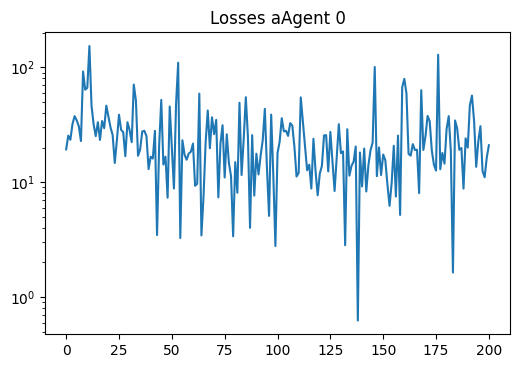

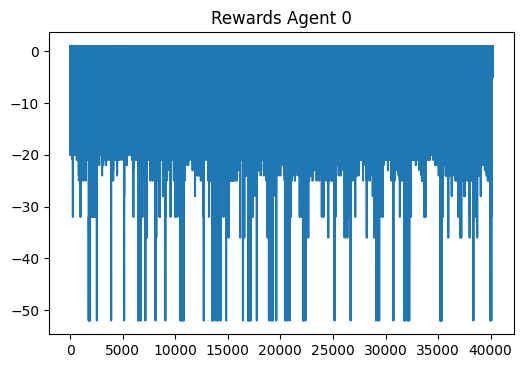

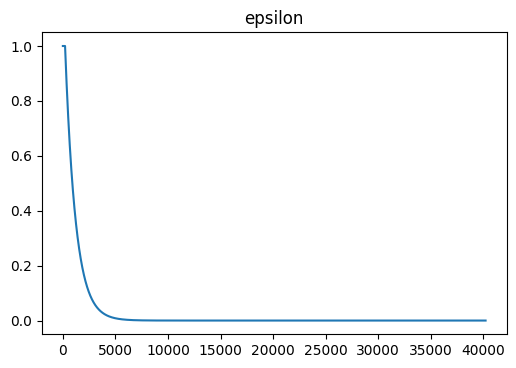

[array([0.09652926, 0.9034707 ], dtype=float32), array([0.0728841, 0.9271159], dtype=float32), array([0.09450118, 0.9054988 ], dtype=float32), array([0.06680494, 0.93319505], dtype=float32), array([0.0636415 , 0.93635845], dtype=float32), array([0.13649002, 0.86350995], dtype=float32), array([0.05705659, 0.94294333], dtype=float32), array([0.04021323, 0.9597867 ], dtype=float32), array([0.05290367, 0.9470963 ], dtype=float32), array([0.0521574, 0.9478426], dtype=float32), array([0.03008172, 0.9699183 ], dtype=float32), array([0.01810137, 0.9818986 ], dtype=float32), array([0.09018416, 0.9098159 ], dtype=float32), array([0.15885605, 0.8411439 ], dtype=float32), array([0.08872931, 0.9112706 ], dtype=float32), array([0.06453352, 0.9354665 ], dtype=float32), array([0.06857859, 0.93142134], dtype=float32), array([0.04279268, 0.9572073 ], dtype=float32), array([0.11667845, 0.8833216 ], dtype=float32), array([0.10609791, 0.8939021 ], dtype=float32), array([0.07886987, 0.9211302 ], dtype=float

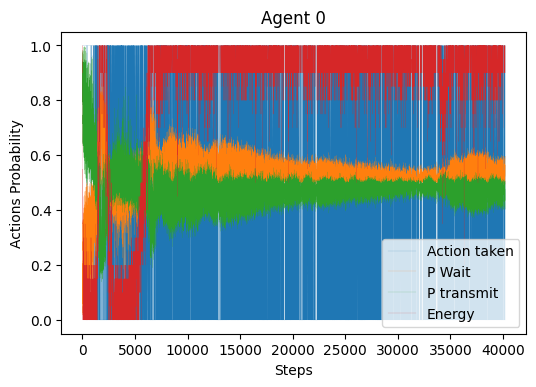

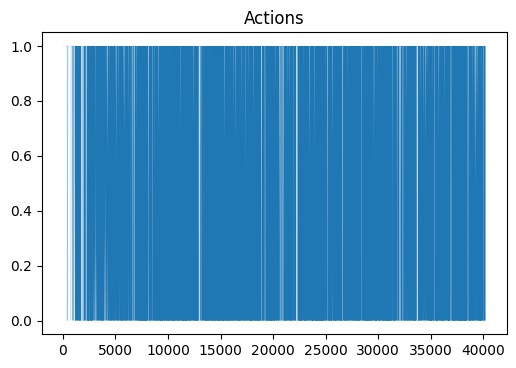

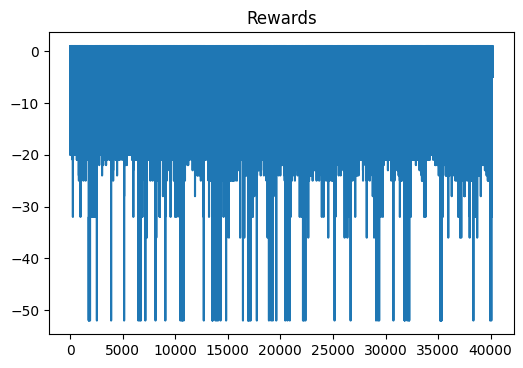

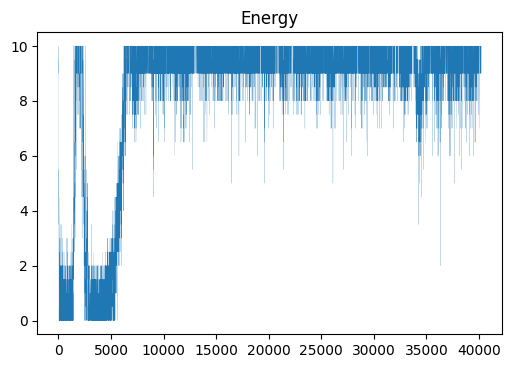

" \ncolors = ['b' ,'r','g', 'y','c', 'm' ,'k','indigo','orange','pink']\nfor j in range(0,len(losses1)):\n  plt.semilogy(np.arange(len(losses1[j])), losses1[j], colors[j])\nplt.legend()\nplt.show()\n\nfor j in range(0,len(losses2)):\n  plt.semilogy(np.arange(len(losses2[j])), losses2[j], colors[j])\nplt.legend()\nplt.show()\n"

In [9]:
from logging import raiseExceptions
window_size = DEFAULT_WINDOW_SIZE
gamma = 0.2
learning_rate = 0.005
epsilon = 1
number_of_agents = 1
time = 0
gen = event_gen(0)

rewards = []
losses_opt =[]

for x in range(0,1):
  #learning_rate = learning_rate+x/1000
  #gamma = gamma/10
  good_reward = 3
  #init data collectors
  DQN_input = [[]for i in range(number_of_agents)]
  outputs = [[]for i in range(number_of_agents)]
  Q_values = [[]for i in range(number_of_agents)]
  DQN_input_coll = [[]for i in range(number_of_agents)]
  actions = [[]for i in range(number_of_agents)]
  energys = [[]for i in range(number_of_agents)]
  losses = [[]for i in range(number_of_agents)]
  reward_coll=[[]for i in range(number_of_agents)]
  transmit_env = []
  transmit_agents = []
  epsilons = []

  "Main code"
  ###########################################################

  #init: create envs and agents

  ###########################################################
  channel = np.zeros(window_size) #global channel

  initial_sensed_history = np.zeros(window_size)

  for i in range(number_of_agents):
    transmit_env = np.append(transmit_env, (transmit_wait(0,window_size, initial_sensed_history))) #agent's envs
    transmit_agents = np.append(transmit_agents, (DQN_agent(learning_rate, gamma, window_size))) #agents 

  
  ###########################################################

  #Round 1: agents draw actions without prior knowladge (epsilon = 1)

  ###########################################################
  transmit_agents_actions = [[]for i in range(number_of_agents)]
  transmit_agents_rewards = [[]for i in range(number_of_agents)]
  sensed_history = [[]for i in range(number_of_agents)]
  energy = [[]for i in range(number_of_agents)]
  urgencies = [[]for i in range(number_of_agents)]
  silent_time = np.ones(window_size) * window_size

  #init all channels to last time step
  for i in range(number_of_agents):
    transmit_env[i].state =  initial_sensed_history , transmit_env[i].energy , silent_time[i], urgencies[i] #change for init
    transmit_env[i].new_state =  initial_sensed_history , transmit_env[i].energy, silent_time[i], urgencies[i]

  '''time step'''
  transmit_env[i].state = transmit_env[i].new_state
  #transmit/wait agents take a random action (epsilon = 1) at random
  for i in range(number_of_agents):
    transmit_agents_actions[i] = transmit_agents[i].choose_action(transmit_env[i].state , 1)
  
    

  #change to the new satate
  for i in range(number_of_agents):
    #decompose all states
    sensed_history[i] , energy[i] , silent_time[i] , urgencies[i] = transmit_env[i].state
    sensed_history[i] = np.append(sensed_history[i],0) # append dummy equal to silence on all agent's sensed channels
  
  #if some agent transmitted, change other's states (append turns to 1 instead) 
  for i in range(number_of_agents):
    if transmit_agents_actions[i] == 1:
      #change all other agents sensed channel
      for j in range(number_of_agents):
        
        #the agent cant hear itself. its chanel doesnt change when it transmits
        if j == i: 
          continue
        else:
          sensed_history[i][-1] = 1 #everyone else hears it
      if energy[i] > 0.5:
        energy[i] = energy[i] - 1 #reduce spent energy 
      #silent_time[i] = 0
      ##########################################################
      #else:
      #  raiseExceptions
      ##########################################################

    else:
      if energy[i] < 10: #fill batery only if not full
        energy[i] = energy[i] + 0.5 #energy replenished for not transmitting
      silent_time[i] += 1
    sensed_history[i] = np.delete(sensed_history[i],0)
    transmit_env[i].new_state = sensed_history[i] , energy[i], silent_time[i], urgencies[i] #new state
    transmit_agents_rewards[i] = transmit_env[i].step(transmit_agents_actions[i])
    if transmit_agents_rewards[i] > 0:
      silent_time[i] = 0
      urgencies[i] = 0
      transmit_env[i].new_state = sensed_history[i] , energy[i], silent_time[i] , urgencies[i] #new state
    #insert to replay buffer 
    #print('agent',i,' ::::',transmit_env[i].state,'::::','action: ', transmit_agents_actions[i], 'reward: ', transmit_agents_rewards[i],'new_state: ', transmit_env[i].new_state)
    transmit_agents[i].insert_history(transmit_env[i].state, transmit_agents_actions[i], transmit_agents_rewards[i], transmit_env[i].new_state) #log agent S,A,R,S' experience
  
  #fill window before colecting buffer data  
  for z in range(window_size):
    actions.append(MARL_time_step(epsilon))
    
  #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
  for z in range(0,HISTORY_BUFFER_LEN):
    actions.append(MARL_time_step(epsilon))
      
  #Learn (DQNs training) on half of the repaly buffer experiences (batch size)
  for i in range(number_of_agents):
    #print(transmit_agents[i].hist,),ory)
    transmit_agents[i].learn(int(HISTORY_BUFFER_LEN/2))
    #update tragets
    transmit_agents[i].copy_parameters()

    #data collection
    losses[i].append(tf.reduce_mean(transmit_agents[i].loss).numpy()) #Save the losses for future visualization

  ###########################################################

  #Round 2: agents draw eplison-greedy actions (epsilon decay from 1 to ~0)

  ###########################################################
  for episodes in range(0,NUMBER_OF_EPISODES):
    
    #Fill a new Replay buffer - take HISTORY_BUFFER_LEN time steps
    for steps in range(0,HISTORY_BUFFER_LEN):
      
      epsilon = 0.999*epsilon #epsilon decay
      actions.append(MARL_time_step(epsilon))
  
    #perform learning
    for i in range(number_of_agents):
      transmit_agents[i].learn(int(HISTORY_BUFFER_LEN/2))
      
      #data collection
      losses[i].append(tf.reduce_mean(transmit_agents[i].loss).numpy()) #Save the losses for future visualization


    #update tragets
    if episodes%5 ==0:
      transmit_agents[i].copy_parameters()
      print('episodes: ', episodes)
  
  losses_opt.append(losses)
  
  print('final step:')
  for i in range(number_of_agents):
    
    print('agent ',i,': ', transmit_env[i].state)
    print('randomness level:' ,epsilon)

    plt.semilogy(np.arange(len(losses[i])), losses[i])
    plt.title('Losses aAgent %i'%i)
    plt.show()
    plt.plot(np.arange(len(reward_coll[i])), reward_coll[i])
    
    plt.title('Rewards Agent %i'%i)
    plt.show()

    plt.plot(np.arange(len(epsilons)), epsilons)
    plt.title('epsilon')
    plt.show()
    #counts, bins = np.histogram(reward_coll[i])
    #plt.hist(bins[:-1], bins, weights=counts)
    #plt.show()
  
    plt.plot(range(0,len(actions[i])),actions[i], linewidth=0.1)
    print(Q_values[i][:])
    plt.plot(range(0,len(Q_values[i])),Q_values[i][:], linewidth=0.1)
    #plt.plot(range(0,len(Q_values[i])),Q_values[i][1], linewidth=0.1)
    plt.plot(range(0,len(energys[i])),np.divide(np.array(energys[i]),10), linewidth=0.1)
    plt.xlabel("Steps")
    plt.ylabel("Actions Probability")
    plt.legend(['Action taken','P Wait','P transmit','Energy'])
    plt.title('Agent %i'%i)
    plt.show()

  for i in range(number_of_agents):
    plt.plot(range(0,len(actions[i])),actions[i], linewidth=0.1)
  plt.title('Actions')
  plt.show()
  for i in range(number_of_agents):
    plt.plot(np.arange(len(reward_coll[i])), reward_coll[i])
  plt.title('Rewards')
  plt.show()

  for i in range(number_of_agents):
    plt.plot(range(0,len(energys[i])),energys[i], linewidth=0.1)
  plt.title('Energy')
  plt.show()
''' 
colors = ['b' ,'r','g', 'y','c', 'm' ,'k','indigo','orange','pink']
for j in range(0,len(losses1)):
  plt.semilogy(np.arange(len(losses1[j])), losses1[j], colors[j])
plt.legend()
plt.show()

for j in range(0,len(losses2)):
  plt.semilogy(np.arange(len(losses2[j])), losses2[j], colors[j])
plt.legend()
plt.show()
'''


In [10]:
agent1slots = 0
agent2slots = 0
collisions = 0
agent_clean = np.zeros(number_of_agents)
wasted = 0
slots = 0
for times in range(0,2*HISTORY_BUFFER_LEN):
  slots+=1
  transmit_agents_actions = MARL_time_step(0)
  
  for i in range(number_of_agents):
    sensed_history[i] , energy[i] , silent_time[i] , urgencies[i] = transmit_env[i].new_state
    if transmit_agents_actions[i] == 1 and sum(transmit_agents_actions) == 1 and (sensed_history[i])[-1] == 0:
          agent_clean[i]+=1
    if (sensed_history[i])[-1] == 1 and transmit_agents_actions[i] == 1:
      collisions+=1
  if sum(transmit_agents_actions)>1:
    collisions+=1
  
  if sum(transmit_agents_actions) == 0:
    wasted+=1
      
print(transmit_agents_actions)

print('total time slots: ', slots)
#print('agent 1 all transmit slots:', agent1slots)
#print('agent 2 all transmit slots:', agent2slots)
print('Collisions: ', collisions)
for i in range(number_of_agents):
 print('agent ',i,' clean slots: ', agent_clean[i])
print('wasted slots: ', wasted)


current_energy 10.0
slient_time 9.0
agent 0  :::: (array([0., 1., 1., 1., 1., 0., 0., 0., 0., 1.]), 10.0, 9.0, 0) :::: action:  0 reward:  -1 new_state:  (array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0.]), 10.0, 10.0, 0)
current_energy 10.0
slient_time 10.0
agent 0  :::: (array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0.]), 10.0, 10.0, 0) :::: action:  0 reward:  -1 new_state:  (array([1., 1., 1., 0., 0., 0., 0., 1., 0., 0.]), 10.0, 10.0, 0)
current_energy 10.0
slient_time 10.0
agent 0  :::: (array([1., 1., 1., 0., 0., 0., 0., 1., 0., 0.]), 10.0, 10.0, 0) :::: action:  1 reward:  1 new_state:  (array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), 9.0, 0.0, 0)
current_energy 9.0
slient_time 0.0
agent 0  :::: (array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0.]), 9.0, 0.0, 0) :::: action:  0 reward:  0 new_state:  (array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 9.5, 1.0, 0)
current_energy 9.5
slient_time 1.0
agent 0  :::: (array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 9.5, 1.0, 0) :::: action:  0 

In [11]:

'''
def f(x, y):
    xx, yy = np.meshgrid(x, y)

    zz = xx + yy
    return zz
print( np.vstack(Q_values[0])[:,0].shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(range(0,len(Q_values[0])), range(0,len(Q_values[0])), f(np.vstack(Q_values[0])[:,0],np.vstack(Q_values[0])[:,0]), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Agent 1')
ax.set_ylabel('Agent 2')
ax.set_zlabel('P Wait');

'''

"\ndef f(x, y):\n    xx, yy = np.meshgrid(x, y)\n\n    zz = xx + yy\n    return zz\nprint( np.vstack(Q_values[0])[:,0].shape)\nfig = plt.figure()\nax = plt.axes(projection='3d')\nax.plot_surface(range(0,len(Q_values[0])), range(0,len(Q_values[0])), f(np.vstack(Q_values[0])[:,0],np.vstack(Q_values[0])[:,0]), rstride=1, cstride=1,\n                cmap='viridis', edgecolor='none')\nax.set_xlabel('Agent 1')\nax.set_ylabel('Agent 2')\nax.set_zlabel('P Wait');\n\n"